In [1]:
import cv2
import os
import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/siamese-registration')

from datasets import RandomTransformationDataset
from models import *
from utils import get_transformation_matrix

In [ ]:
path = "/content/drive/MyDrive/data"
output_path = "/content/drive/MyDrive/outputs"

In [ ]:
test_dataset = RandomTransformationDataset(
    transforms=transforms.Compose([
        transforms.ToTensor(),
    ]),
    path=os.path.join(path, "test.pkl"),
    path_prefix="/content/drive/MyDrive"
)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=10, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Initial = fc

# concat
#folder = "01"
#checkpoint = "models/01/model-9.pt"
#folder = "02_resnet18_MSE"
#checkpoint = "model-9.pt"
#outputs_path = "/content/drive/MyDrive/outputs"
#model = initial_siamese_resnet18(1, 7, "concatenation")
#model.load_state_dict(torch.load(os.path.join(outputs_path, folder, checkpoint), map_location=device))

# corr
folder = "07_resnet18_MSE_corr"
checkpoint = "checkpoint-9.pt"
outputs_path = "/content/drive/MyDrive/outputs"
model = initial_siamese_resnet18(1, 7, "correlation", )
model.load_state_dict(torch.load(os.path.join(outputs_path, folder, checkpoint), map_location=device)['model_state_dict'])
model.cuda()
model.eval()

print(f"Running on {device}")

Running on cuda


In [ ]:
# Reg
folder = "08_resnet18_MSE_corr_reg" #14_resnet18_MSE_corr_reg
checkpoint = "checkpoint-20.pt" # checkpoint-14.pt
outputs_path = "/content/drive/MyDrive/outputs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = siamese_resnet18(1, 7, "correlation", channels=[384, 128, 64])
model.load_state_dict(torch.load(os.path.join(outputs_path, folder, checkpoint), map_location=device)['model_state_dict'])
model.cuda()
model.eval()

print(f"Running on {device}")

In [ ]:
models_info = [
    {
        "folder": "02_resnet18_MSE",
        "checkpoint": "model-9.pt",
        "type": "concatenation"
    },
    {
        "folder": "16_sub_MSE_fc",
        "checkpoint": "checkpoint-20.pt",
        "type": "subtraction"
    },
    {
        "folder": "07_resnet18_MSE_corr_2",
        "checkpoint": "checkpoint-24.pt",
        "type": "correlation"
    },
]
outputs_path = "/content/drive/MyDrive/outputs"

In [ ]:
models = []
for m_i in models_info:
    model = initial_siamese_resnet18(1, 7, m_i["type"])
    if m_i["type"] == "concatenation":
        model.load_state_dict(torch.load(os.path.join(outputs_path, m_i["folder"], m_i["checkpoint"]), map_location=device))
    else:
        model.load_state_dict(torch.load(os.path.join(outputs_path, m_i["folder"], m_i["checkpoint"]), map_location=device)['model_state_dict'])
    model.cuda()
    model.eval()
    models.append(model)


In [ ]:
#del models

In [ ]:
loader = iter(test_loader)

In [ ]:
import time


img0, img1, params = next(loader)
img0, img1, params = img0.to(device=device), img1.to(device=device), params.to(device=device)
# init cuda
outputs = model(img0, img1)

img0, img1, params = next(loader)
img0, img1, params = img0.to(device=device), img1.to(device=device), params.to(device=device)

start = time.perf_counter()
outputs = model(img0, img1)
end = time.perf_counter()

inference = end - start

image0 = img0.detach().cpu().numpy()[0, 0, :, :]
image1 = img1.detach().cpu().numpy()[0, 0, :, :]
rows, cols = image0.shape
center = (cols//2, rows//2)

tx, ty, sx, sy, shx, shy, q = outputs.detach().cpu().numpy().reshape(-1).tolist()
start = time.perf_counter()
matrix = get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q)
matrix_opencv = np.float32(matrix.flatten()[:6].reshape(2, 3))
inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
inversed_image1 = cv2.warpAffine(image1, inverse_matrix, (cols, rows))
end = time.perf_counter()

registration = end - start


print(f"inference: {inference*1000:.3f} ms \nregistration: {registration*1000:.3f} ms")

inference: 22.749 ms 
registration: 2.705 ms


In [ ]:
param_list = []
outputs1 = []
outputs2 = []
outputs3 = []

with tqdm(test_loader) as validation_progress:
    for img0, img1, params in validation_progress:
        img0, img1, params = img0.to(device=device), img1.to(device=device), params.to(device=device)
        param_list.append(params.detach().cpu().numpy().reshape(-1).tolist())
        out = models[0](img0, img1)
        outputs1.append(out.detach().cpu().numpy().reshape(-1).tolist())
        out = models[1](img0, img1)
        outputs2.append(out.detach().cpu().numpy().reshape(-1).tolist())
        out = models[2](img0, img1)
        outputs3.append(out.detach().cpu().numpy().reshape(-1).tolist())

  0%|          | 0/8000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 8000/8000 [09:58<00:00, 13.37it/s]


In [5]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
d = {'params':param_list, 'outputs1':outputs1, 'outputs2':outputs2, 'outputs3':outputs3}

In [ ]:
df = pd.DataFrame(d, columns=['params','outputs1', 'outputs2', 'outputs3'])

In [ ]:
#df.to_csv(os.path.join("/content/drive/MyDrive/outputs", "outputs-fc.csv"))

In [22]:
# change fc/reg
df = pd.read_csv("/content/drive/MyDrive/outputs/outputs-reg2.csv")

In [23]:
df.outputs1 = df.outputs1.apply(lambda x: np.array(json.loads(x)))
df.outputs2 = df.outputs2.apply(lambda x: np.array(json.loads(x)))
df.outputs3 = df.outputs3.apply(lambda x: np.array(json.loads(x)))
df.params = df.params.apply(lambda x: np.array(json.loads(x)))

In [89]:
df['comp1'] = np.abs(df['outputs1'] - df['params'])
df['comp2'] = np.abs(df['outputs2'] - df['params'])
df['comp3'] = np.abs(df['outputs3'] - df['params'])
df['comp_percentage1'] = np.abs(np.divide(np.subtract(df['outputs1'], df['params']), df['params'])*100)
df['comp_percentage2'] = np.abs(np.divide(np.subtract(df['outputs2'], df['params']), df['params'])*100)
df['comp_percentage3'] = np.abs(np.divide(np.subtract(df['outputs3'], df['params']), df['params'])*100)

In [83]:
df

,Unnamed: 0,params,outputs1,outputs2,outputs3,err1,err2,err3,comp1,comp2,comp3,comp_percentage1,comp_percentage2,comp_percentage3
0,0,"[-22.731979370117188, 10.535877227783203, 0.98...","[-23.041061401367188, 11.27856731414795, 0.865...","[-17.94979476928711, 14.04458999633789, 0.9217...","[-22.7293701171875, 12.370938301086426, 0.9769...",0.009777,0.004821,0.004512,"[0.30908203125, 0.7426900863647461, 0.12146168...","[4.782184600830078, 3.5087127685546875, 0.0648...","[0.0026092529296875, 1.8350610733032227, 0.009...","[1.3596793583945903, 7.049152816684932, 12.310...","[21.03725559031873, 33.30252140089655, 6.57414...","[0.011478335815831108, 17.417259461453767, 0.9..."
1,1,"[-32.71163558959961, 24.97426414489746, 1.0358...","[-31.04298973083496, 24.04233169555664, 0.9635...","[-9.645130157470703, 17.91790771484375, 0.9790...","[-31.78717613220215, 25.07256317138672, 1.0207...",0.004338,0.003864,0.006706,"[1.6686458587646484, 0.9319324493408203, 0.072...","[23.066505432128906, 7.056356430053711, 0.0567...","[0.9244594573974609, 0.09829902648925781, 0.01...","[5.101077426086211, 3.7315712043961273, 6.9807...","[70.51468083565564, 28.254511881165513, 5.4834...","[2.8260875396013065, 0.3936012925904024, 1.458..."
2,2,"[46.44846725463867, -39.76923751831055, 0.9759...","[46.48339080810547, -34.35281753540039, 0.9745...","[51.099365234375, -36.440704345703125, 1.04722...","[46.785274505615234, -35.346527099609375, 1.00...",0.009991,0.026046,0.012433,"[0.034923553466796875, 5.416419982910156, 0.00...","[4.650897979736328, 3.328533172607422, 0.07128...","[0.3368072509765625, 4.422710418701172, 0.0255...","[0.07518774144976584, 13.619622403915411, 0.13...","[10.013027887958685, 8.369617775736584, 7.3046...","[0.725120269588501, 11.120933401513842, 2.6183..."
3,3,"[-5.850210189819336, 36.64148712158203, 1.0407...","[-4.806971073150635, 38.516510009765625, 0.993...","[-1.3097401857376099, 38.81648254394531, 1.013...","[-7.617467880249023, 35.33661651611328, 1.0491...",0.008562,0.007140,0.006822,"[1.0432391166687012, 1.8750228881835938, 0.047...","[4.540470004081726, 2.1749954223632812, 0.0276...","[1.7672576904296875, 1.30487060546875, 0.00840...","[17.832506573595744, 5.117212852092991, 4.5612...","[77.61208327152332, 5.9358819557358995, 2.6597...","[30.208447783724218, 3.5611835325869574, 0.807..."
4,4,"[16.121307373046875, -17.02111053466797, 0.977...","[16.61880874633789, -16.568479537963867, 0.940...","[19.20916175842285, -13.434715270996094, 0.988...","[16.111061096191406, -16.42022705078125, 0.977...",0.003434,0.003654,0.002665,"[0.4975013732910156, 0.45263099670410156, 0.03...","[3.0878543853759766, 3.586395263671875, 0.0117...","[0.01024627685546875, 0.6008834838867188, 0.00...","[3.0859865256510486, 2.6592330493489214, 3.737...","[19.153870799204185, 21.07027773756147, 1.2006...","[0.06355735684687362, 3.530224909020251, 0.046..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7995,"[-6.690968990325928, -3.2302439212799072, 1.00...","[-8.042827606201172, -5.096728324890137, 0.977...","[-7.577261924743652, 5.228134632110596, 0.9300...","[-5.86894416809082, -2.640068292617798, 1.0172...",0.002901,0.002748,0.002891,"[1.3518586158752441, 1.8664844036102295, 0.028...","[0.8862929344177246, 8.458378553390503, 0.0750...","[0.8220248222351074, 0.5901756286621094, 0.012...","[20.204227785688676, 57.7815313362057, 2.79171...","[13.246107338102487, 261.8495308564522, 7.4660...","[12.2855870864687, 18.270311562981483, 1.20559..."
7996,7996,"[-38.84047317504883, 41.68067169189453, 1.0367...","[-39.21367645263672, 45.6358528137207, 0.97395...","[-33.035667419433594, 15.889723777770996, 1.14...","[-38.785377502441406, 41.69853973388672, 1.055...",0.026495,0.025720,0.028888,"[0.3732032775878906, 3.955181121826172, 0.0627...","[5.804805755615234, 25.790947914123535, 0.1062...","[0.055095672607421875, 0.0178680419921875, 0.0...","[0.9608618203643227, 9.489245161553669, 6.0567...","[14.945249841457258, 61.87747669896355, 10.2

In [88]:
np.abs(np.divide(np.subtract(df['outputs1'], df['params']), df['params'])*100)

0       [1.3596793583945903, 7.049152816684932, 12.310...
1       [5.101077426086211, 3.7315712043961273, 6.9807...
2       [0.07518774144976584, 13.619622403915411, 0.13...
3       [17.832506573595744, 5.117212852092991, 4.5612...
4       [3.0859865256510486, 2.6592330493489214, 3.737...
                              ...                        
7995    [20.204227785688676, 57.7815313362057, 2.79171...
7996    [0.9608618203643227, 9.489245161553669, 6.0567...
7997    [0.22737411025926807, 1.5829877970950443, 10.0...
7998    [0.7591432895988537, 13.166390475457165, 9.223...
7999    [5.427323682308581, 31.027653068233302, 4.5468...
Length: 8000, dtype: object

In [90]:
df1 = pd.DataFrame(df['comp1'].to_list(), columns = ['tx', 'ty', 'sx', 'sy', 'shx', 'shy', 'q'])
#df1.insert(7, "q_deg", df1.q.apply(lambda x: np.degrees(x)))
df2 = pd.DataFrame(df['comp2'].to_list(), columns = ['tx', 'ty', 'sx', 'sy', 'shx', 'shy', 'q'])
df3 = pd.DataFrame(df['comp3'].to_list(), columns = ['tx', 'ty', 'sx', 'sy', 'shx', 'shy', 'q'])
dfp1 = pd.DataFrame(df['comp_percentage1'].to_list(), columns = ['tx', 'ty', 'sx', 'sy', 'shx', 'shy', 'q'])
dfp2 = pd.DataFrame(df['comp_percentage2'].to_list(), columns = ['tx', 'ty', 'sx', 'sy', 'shx', 'shy', 'q'])
dfp3 = pd.DataFrame(df['comp_percentage3'].to_list(), columns = ['tx', 'ty', 'sx', 'sy', 'shx', 'shy', 'q'])

In [75]:
df1

,tx,ty,sx,sy,shx,shy,q
0,0.309082,0.742690,0.121462,0.073139,0.005671,0.020931,0.001338
1,1.668646,0.931932,0.072308,0.013924,0.076785,0.007013,0.055519
2,0.034924,5.416420,0.001342,0.008611,0.026638,0.010060,0.045555
3,1.043239,1.875023,0.047473,0.057199,0.063953,0.064091,0.029490
4,0.497501,0.452631,0.036517,0.030816,0.005086,0.001139,0.022817
...,...,...,...,...,...,...,...
7995,1.351859,1.866484,0.028060,0.015728,0.009579,0.017854,0.060633
7996,0.373203,3.955181,0.062793,0.018447,0.089283,0.132403,0.070405
7997,0.109333,0.332584,0.095400,0.101431,0.121017,0.045402,0.086643
7998,0.205589,3.323488,0.096313,0.084249,0.020707,0.116219,0.069697


In [76]:
dfp1

,tx,ty,sx,sy,shx,shy,q
0,101.359679,92.950847,87.689013,92.564959,50.305051,58.363416,98.656133
1,105.101077,96.268429,93.019299,98.567059,207.422372,114.618553,9.253630
2,99.924812,113.619622,99.862461,99.164690,9.859290,84.428426,73.702809
3,117.832507,94.882787,95.438721,94.070730,26.084908,780.352945,2.394714
4,96.914013,102.659233,96.262418,97.023435,105.159628,103.434443,543.173004
...,...,...,...,...,...,...,...
7995,120.204228,157.781531,97.208281,98.464841,66.893905,246.001244,45.696443
7996,100.960862,90.510755,93.943272,98.187762,276.629237,417.547902,340.557417
7997,100.227374,98.417012,89.962432,90.101771,489.299761,62.916505,179.000233
7998,99.240857,113.166390,90.776579,91.877799,125.656918,208.638764,158.064281


In [91]:
dfp3.describe()

,tx,ty,sx,sy,shx,shy,q
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,20.498163,29.596921,1.028343,1.559927,281.753413,412.527406,243.502600
std,355.559859,597.261753,0.836430,1.168441,4647.509614,10845.891438,3748.645415
min,0.000598,0.000071,0.000061,0.000314,0.000608,0.027446,0.001540
25%,1.619768,1.891876,0.399209,0.658168,31.517591,31.273995,16.144204
50%,3.781301,4.263067,0.843887,1.327383,67.329586,68.269663,36.350831
75%,8.587791,9.476331,1.454363,2.239422,130.482630,129.756270,81.406711
max,27054.078678,49357.855710,13.442038,17.908941,390603.537003,723362.053105,262123.916070


In [14]:
df2.describe()

,tx,ty,sx,sy,shx,shy,q
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03
mean,4.771066,5.483540,0.051971,0.050724,0.055031,0.050590,4.891752e-02
std,4.803953,6.847029,0.040789,0.039034,0.040736,0.037863,3.790874e-02
min,0.000539,0.000795,0.000009,0.000017,0.000002,0.000005,7.078052e-07
25%,1.589002,1.594611,0.020202,0.020821,0.022841,0.020181,1.909955e-02
50%,3.453884,3.438026,0.043217,0.042656,0.047820,0.043200,4.116112e-02
75%,6.237090,6.669872,0.073678,0.071877,0.078329,0.072601,6.958331e-02
max,49.060408,87.571041,0.353499,0.346017,0.241741,0.229695,2.813702e-01


In [62]:
df3.describe()

,tx,ty,sx,sy,shx,shy,q,t_dis
count,8000.000000,8000.000000,8.000000e+03,8000.000000,8.000000e+03,8.000000e+03,8000.000000,8.000000e+03
mean,1.133738,1.253512,1.027244e-02,0.015548,3.456423e-02,3.450277e-02,0.034980,7.690614e+02
std,1.645542,1.588312,8.332399e-03,0.011562,2.522270e-02,2.549192e-02,0.025900,2.532901e+04
min,0.000012,0.000027,5.960464e-07,0.000003,4.395843e-07,7.045455e-07,0.000002,1.144654e-02
25%,0.390733,0.448469,3.956735e-03,0.006577,1.403182e-02,1.393249e-02,0.013896,3.672503e+01
50%,0.847696,0.979008,8.451641e-03,0.013271,3.002806e-02,2.964320e-02,0.030115,6.976035e+01
75%,1.527639,1.718599,1.443224e-02,0.022437,5.028143e-02,4.984044e-02,0.051239,1.069651e+02
max,46.755553,48.502072,1.396888e-01,0.175487,1.471737e-01,1.445694e-01,0.190456,2.115026e+06


In [95]:
df3["t_dis"] = np.abs(((df3['tx']-df3['ty']) / df3['ty'])*100)
lol = dfp3.describe()
lol["t_dis"] = ((lol['tx']-lol['ty']) / lol['ty'])*100
lol["s_dis"] = ((lol['sx']-lol['sy']) / lol['sy'])*100
lol["sh_dis"] = ((lol['shx']-lol['shy']) / lol['shy'])*100
lol

,tx,ty,sx,sy,shx,shy,q,t_dis,s_dis,sh_dis
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,0.000000,0.000000,0.000000
mean,20.498163,29.596921,1.028343,1.559927,281.753413,412.527406,243.502600,-30.742243,-34.077480,-31.700680
std,355.559859,597.261753,0.836430,1.168441,4647.509614,10845.891438,3748.645415,-40.468336,-28.414896,-57.149584
min,0.000598,0.000071,0.000061,0.000314,0.000608,0.027446,0.001540,743.237846,-80.659971,-97.784906
25%,1.619768,1.891876,0.399209,0.658168,31.517591,31.273995,16.144204,-14.382964,-39.345448,0.778911
50%,3.781301,4.263067,0.843887,1.327383,67.329586,68.269663,36.350831,-11.300928,-36.424768,-1.377005
75%,8.587791,9.476331,1.454363,2.239422,130.482630,129.756270,81.406711,-9.376408,-35.056307,0.559788
max,27054.078678,49357.855710,13.442038,17.908941,390603.537003,723362.053105,262123.916070,-45.187897,-24.942306,-46.001655


In [ ]:
col = df1.loc[: , "q":"q"]
tmp = pd.DataFrame()
tmp['tmp'] = col.mean(axis=1)
tmp.describe()

,tmp
count,8000.000000
mean,0.041588
std,0.031470
min,0.000002
25%,0.016284
50%,0.035001
75%,0.059752
max,0.194675


In [ ]:
tr1 = df1.loc[: , "tx":"ty"]
tr2 = df2.loc[: , "tx":"ty"]
tr3 = df3.loc[: , "tx":"ty"]
tr = pd.DataFrame().assign(
    concatenation = tr1.mean(axis=1),
    subtraction = tr2.mean(axis=1),
    correlation = tr3.mean(axis=1)

)

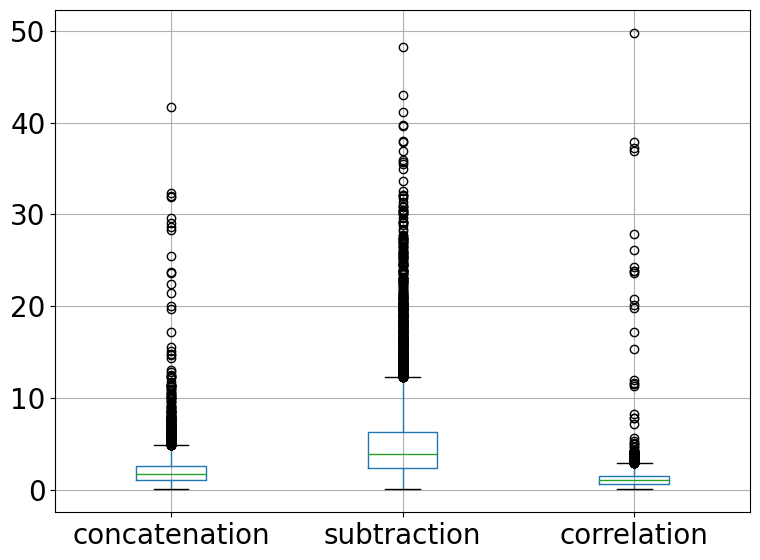

In [ ]:
plt.figure(figsize=(8,6))
plt.rc('font', size=20)
boxplot = tr.boxplot(column = ['concatenation', 'subtraction', 'correlation'])
plt.tight_layout()
plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "tr-reg.png"))

In [ ]:
s1 = df1.loc[: , "sx":"sy"]
s2 = df2.loc[: , "sx":"sy"]
s3 = df3.loc[: , "sx":"sy"]
s = pd.DataFrame().assign(
    concatenation = s1.mean(axis=1),
    subtraction = s2.mean(axis=1),
    correlation = s3.mean(axis=1)

)

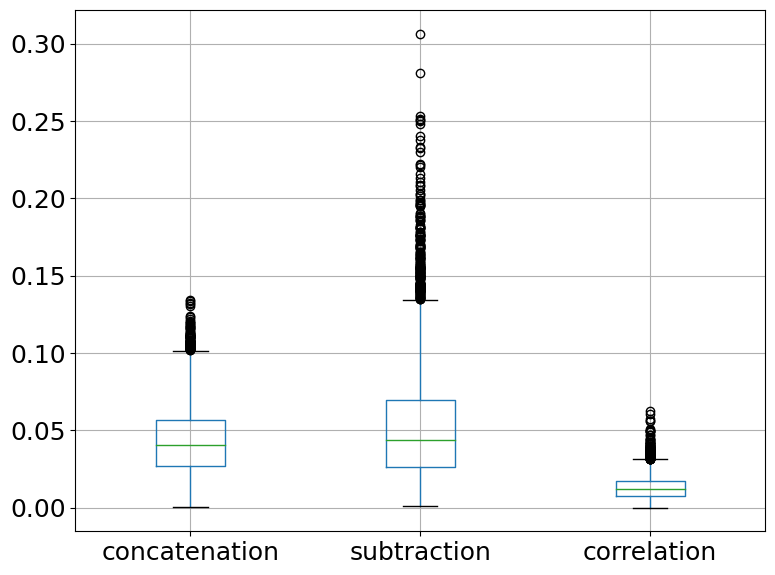

In [ ]:
plt.figure(figsize=(8,6))
plt.rc('font', size=15)
boxplot = s.boxplot(column = ['concatenation', 'subtraction', 'correlation'], fontsize="large")
plt.tight_layout()
plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "s-reg.png"))

In [ ]:
sh1 = df1.loc[: , "shx":"shy"]
sh2 = df2.loc[: , "shx":"shy"]
sh3 = df3.loc[: , "shx":"shy"]
sh = pd.DataFrame().assign(
    concatenation = sh1.mean(axis=1),
    subtraction = sh2.mean(axis=1),
    correlation = sh3.mean(axis=1)

)

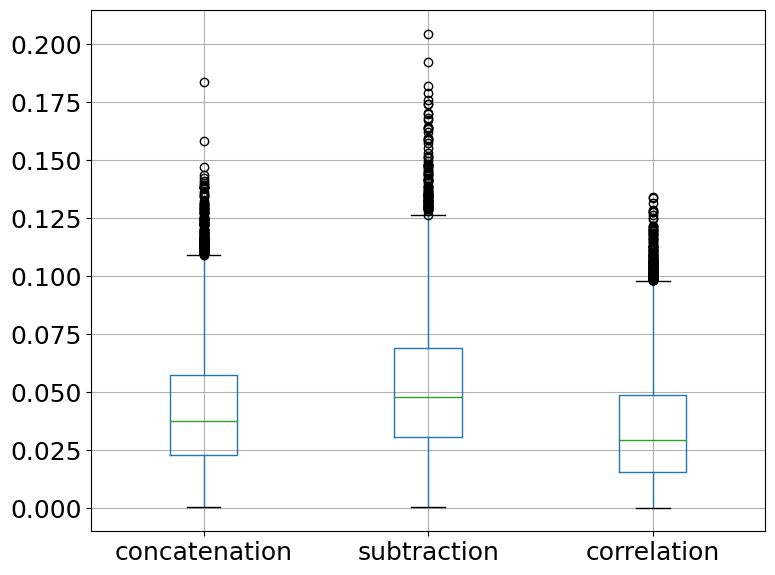

In [ ]:
plt.figure(figsize=(8,6))
plt.rc('font', size=15)
boxplot = sh.boxplot(column = ['concatenation', 'subtraction', 'correlation'], fontsize="large")
plt.tight_layout()
plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "sh-reg.png"))

In [ ]:
q1 = df1.loc[: , "q":"q"]
q2 = df2.loc[: , "q":"q"]
q3 = df3.loc[: , "q":"q"]
q = pd.DataFrame().assign(
    concatenation = q1.mean(axis=1),
    subtraction = q2.mean(axis=1),
    correlation = q3.mean(axis=1)

)

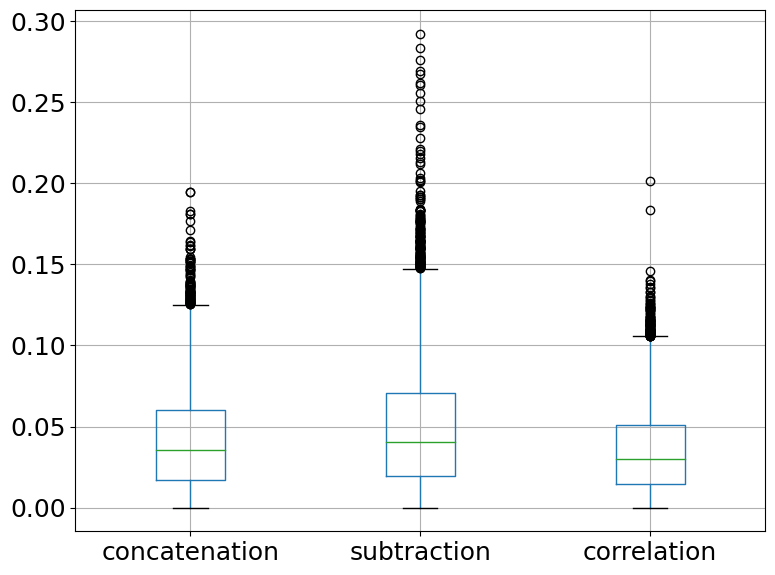

In [ ]:
plt.figure(figsize=(8,6))
plt.rc('font', size=15)
boxplot = q.boxplot(column = ['concatenation', 'subtraction', 'correlation'], fontsize="large")
plt.tight_layout()
plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "q-reg.png"))

In [ ]:
df2.describe().to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &           tx &           ty &           sx &           sy &          shx &          shy &            q &        q\\_deg \\\\\n\\midrule\ncount &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 \\\\\nmean  &     6.633702 &     8.167822 &     0.025623 &     0.027611 &     0.050134 &     0.048725 &     0.086865 &     4.977010 \\\\\nstd   &     6.608164 &     7.915253 &     0.017439 &     0.020407 &     0.033103 &     0.032673 &     0.057322 &     3.284331 \\\\\nmin   &     0.002094 &     0.002056 &     0.000009 &     0.000002 &     0.000008 &     0.000006 &     0.000017 &     0.000989 \\\\\n25\\%   &     2.115572 &     2.682322 &     0.011117 &     0.011562 &     0.023105 &     0.021718 &     0.039723 &     2.275949 \\\\\n50\\%   &     4.715327 &     5.885535 &     0.023280 &     0.024343 &     0.045576 &     0.044166 &     0.079518 &     4.556023 \\\\\n75\\%   &     8.83418

In [ ]:
dft = pd.DataFrame().assign(
    tx1 = df1.tx,
    tx2 = df2.tx,
    tx3 = df3.tx,
    ty1 = df1.ty,
    ty2 = df2.ty,
    ty3 = df3.ty

)

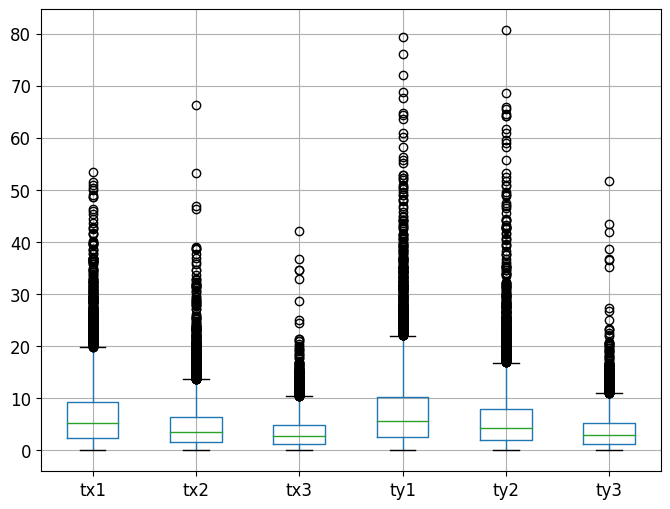

In [ ]:
plt.figure(figsize=(8,6))
boxplot = dft.boxplot(column = ['tx1', 'tx2', 'tx3', 'ty1', 'ty2', 'ty3'], fontsize="large")

In [ ]:
dfs = pd.DataFrame().assign(
    sx1 = df1.sx,
    sx2 = df2.sx,
    sx3 = df3.sx,
    sy1 = df1.sy,
    sy2 = df2.sy,
    sy3 = df3.sy

)

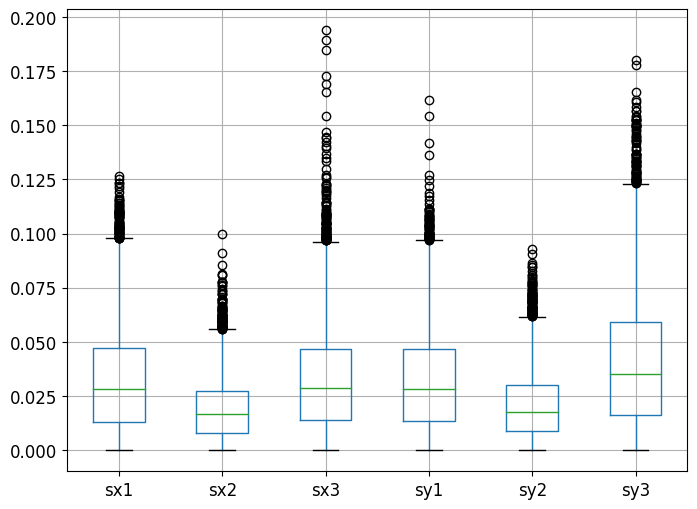

In [ ]:
plt.figure(figsize=(8,6))
boxplot = dfs.boxplot(column = ['sx1', 'sx2', 'sx3', 'sy1', 'sy2', 'sy3'], fontsize="large")

In [ ]:
dfsh = pd.DataFrame().assign(
    shx1 = df1.shx,
    shx2 = df2.shx,
    shx3 = df3.shx,
    shy1 = df1.shy,
    shy2 = df2.shy,
    shy3 = df3.shy

)

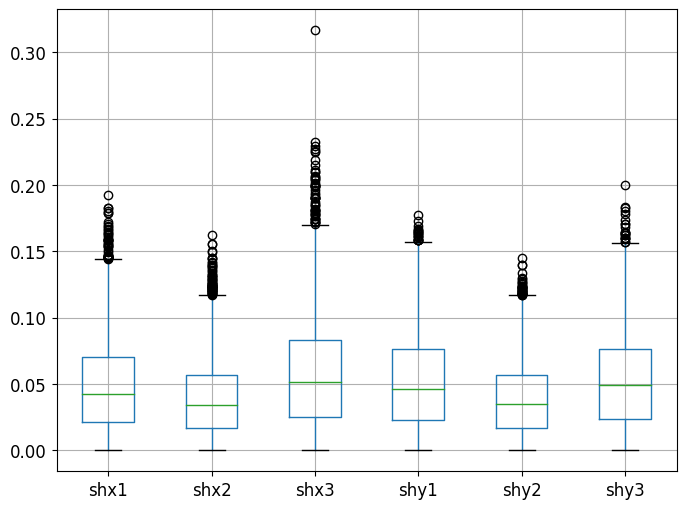

In [ ]:
plt.figure(figsize=(8,6))
boxplot = dfsh.boxplot(column = ['shx1', 'shx2', 'shx3', 'shy1', 'shy2', 'shy3'], fontsize="large")

In [ ]:
dfq = pd.DataFrame().assign(
    q1 = df1.q,
    q2 = df2.q,
    q3 = df3.q

)

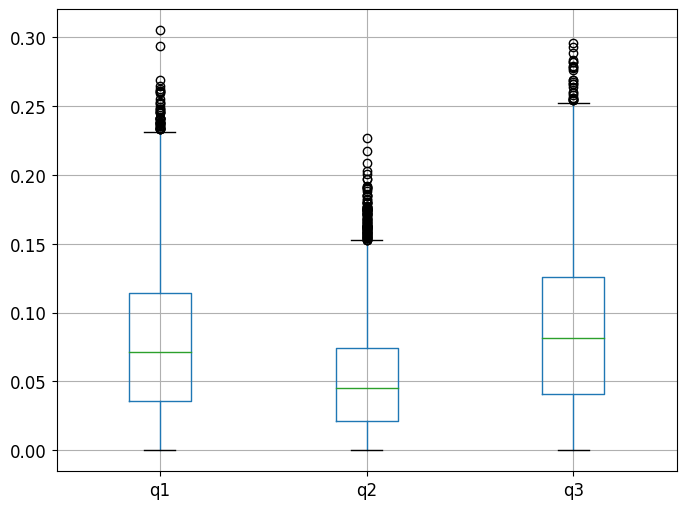

In [ ]:
plt.figure(figsize=(8,6))
boxplot = dfq.boxplot(column = ['q1', 'q2', 'q3'], fontsize="large")

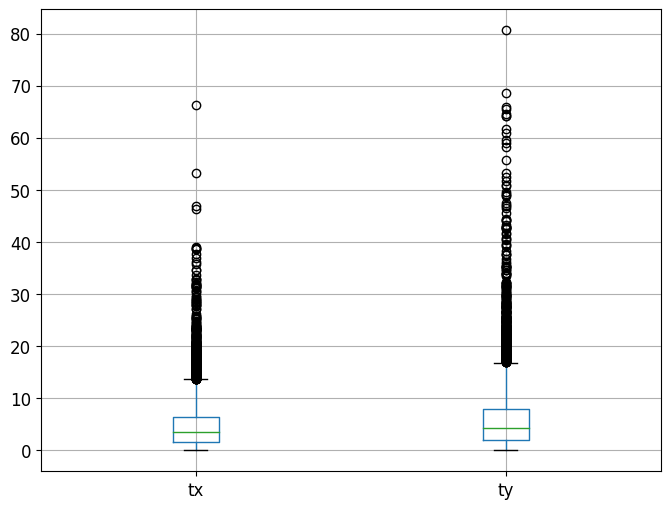

In [ ]:
plt.figure(figsize=(8,6))
boxplot = df2.boxplot(column = ['tx', 'ty',], fontsize="large")
#plt.savefig(os.path.join("/content/drive/MyDrive/plots", "t.png"))

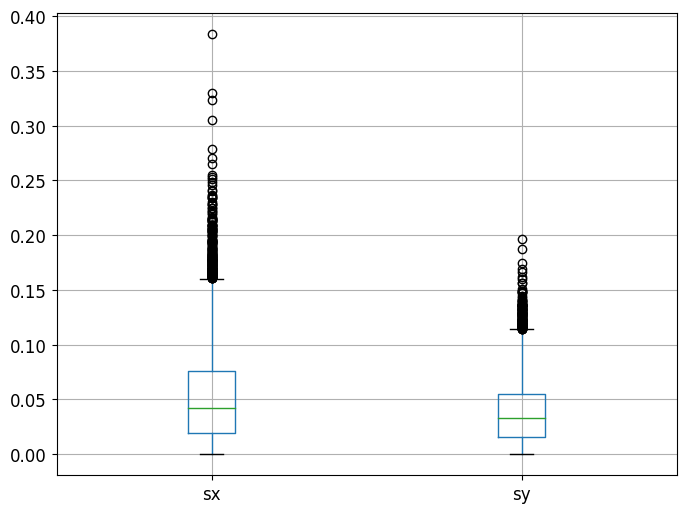

In [ ]:
plt.figure(figsize=(8,6))
boxplot = df2.boxplot(column = ['sx', 'sy',], fontsize="large")
#plt.savefig(os.path.join("/content/drive/MyDrive/plots", "s.png"))

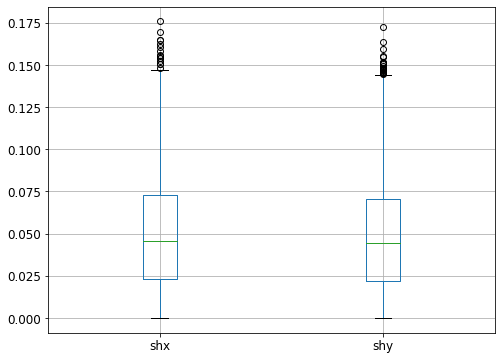

In [ ]:
plt.figure(figsize=(8,6))
boxplot = df2.boxplot(column = ['shx', 'shy',], fontsize="large")
plt.savefig(os.path.join("/content/drive/MyDrive/plots", "sh.png"))

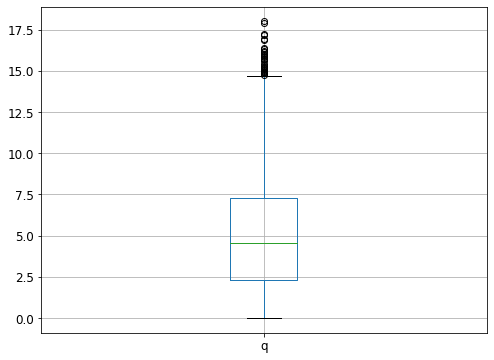

In [ ]:
plt.figure(figsize=(8,6))
boxplot = df2.boxplot(column = ['q'], fontsize="large")
plt.savefig(os.path.join("/content/drive/MyDrive/plots", "q.png"))

In [ ]:
plt.savefig(os.path.join("/content/drive/MyDrive/plots", "q.png"))

<Figure size 432x288 with 0 Axes>